In [1]:
import numpy as np
import pandas as pd
import torch
from EOS_Solver import EoSNetwork, chi2_loss
import matplotlib.pyplot as plt
from TOV_Solver import WaveNetTOV, r2_score
from preprocessing import eos_load_and_preprocess

Using device: cuda


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Input Data

In [3]:
observed_mr = pd.read_csv("data/sample_mr.csv")
observed_eos = pd.read_csv("data/sample_eos.csv")

MR_relations = np.load("data/Y_test.npy")

M_MAX = observed_mr["M"].max()
R_MAX = 16.0
R_MIN = observed_mr["R"].min()


rho_scaled, P_scaled, M_scaled, R_scaled, dM, dR = eos_load_and_preprocess()


# final observed points (from data only)
M_targets =  M_scaled * M_MAX
R_targets = R_scaled * (R_MAX - R_MIN) + R_MIN

M_obs = MR_relations[0][:,0] * M_MAX
R_obs = MR_relations[0][:,1] * (R_MAX - R_MIN) + R_MIN

M_11 (scaled): [0.4331373  0.49286547 0.5523816  0.6117555  0.6695539  0.72596645
 0.7799029  0.82793784 0.86711705 0.8920366  0.9008411 ]
R_11 (scaled): [0.53374034 0.5254837  0.51616544 0.50552535 0.4882767  0.4669477
 0.44013223 0.40380308 0.35811234 0.30345246 0.24394605]
rho_scaled (full): [0.         0.0015873  0.0031746  0.0047619  0.00634921 0.00793651
 0.00952381 0.01111111 0.01269841 0.01428572 0.01587302 0.01746032
 0.01904762 0.02063492 0.02222222 0.02380952 0.02539683 0.02698413
 0.02857143 0.03015873 0.03174603 0.03333334 0.03492064 0.03650794
 0.03809524 0.03968254 0.04126984 0.04285714 0.04444445 0.04603174
 0.04761905 0.04920635 0.05079365 0.05238095 0.05396825 0.05555556
 0.05714286 0.05873016 0.06031746 0.06190476 0.06349207 0.06507937
 0.06666667 0.06825397 0.06984127 0.07142857 0.07301588 0.07460319
 0.07619047 0.07777777 0.07936508 0.08095238 0.08253969 0.08412698
 0.08571429 0.08730159 0.08888889 0.09047619 0.09206349 0.0936508
 0.0952381  0.0968254  0.0984127  0

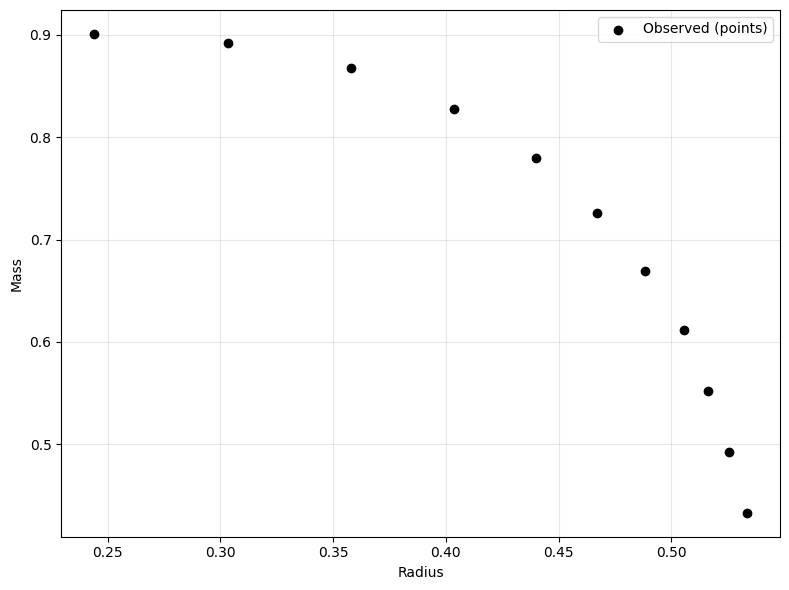

In [4]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(R_scaled, M_scaled, color="black", label="Observed (points)", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

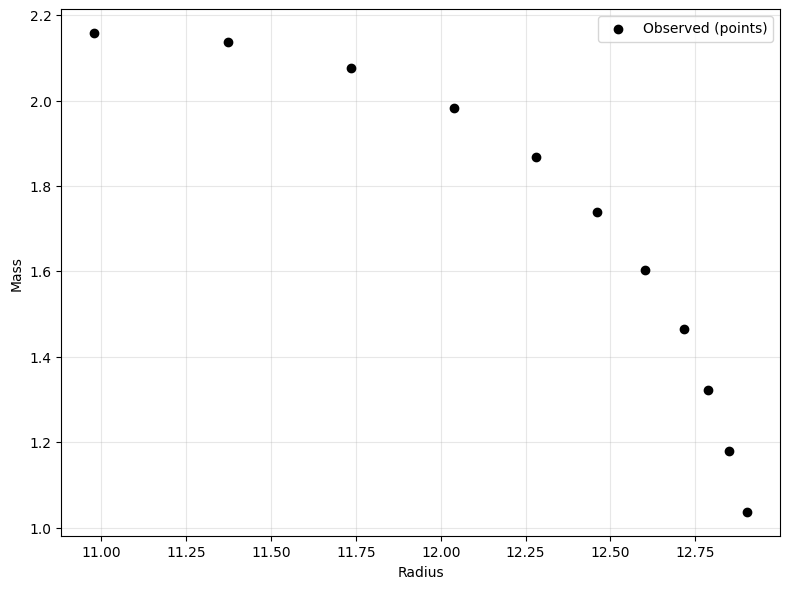

In [5]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(R_targets, M_targets, color="black", label="Observed (points)", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Results

In [6]:
# Load TOV-Solver Network
tov = WaveNetTOV().to(device)
tov.load_state_dict(torch.load("models/tov_solver.pt", map_location=device))
tov.eval()

# Load EoS Network
eos = EoSNetwork().to(device)
eos.load_state_dict(torch.load("models/eos_solver.pt", map_location=device))
eos.eval()


c:\Users\ppsan\repos\NN-Reconstruction\TOV_Solver.py:36: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(self.weight_raw)
C:\Users\ppsan\AppData\Local\Temp\ipykernel_23124\2904587124.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where y

EoSNetwork(
  (act): ELU(alpha=1.0)
  (conv1): ParametrizedConv1d(
    1, 64, kernel_size=(1,), stride=(1,), padding=same
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv2): ParametrizedConv1d(
    64, 64, kernel_size=(1,), stride=(1,), padding=same
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
  (conv3): ParametrizedConv1d(
    64, 1, kernel_size=(1,), stride=(1,), padding=same
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): NonNegative()
      )
    )
  )
)

In [7]:
rho_t = torch.tensor(rho_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)
p_pred = eos(rho_t)

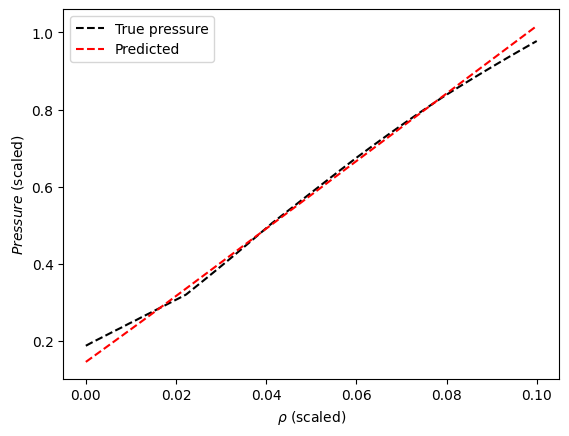

In [8]:
x = rho_scaled.squeeze()

plt.plot(rho_scaled, P_scaled.squeeze(), "--", color="black", label="True pressure", zorder=3)
plt.plot(rho_scaled,  p_pred.detach().cpu().numpy().squeeze(),  "--", color="red", label="Predicted", zorder=3)

plt.xlabel(r"$\rho$ (scaled)")
plt.ylabel(r"$Pressure$ (scaled)")
plt.legend()
plt.show()

In [9]:
p_pred

tensor([[[0.1453],
         [0.1586],
         [0.1720],
         [0.1855],
         [0.1990],
         [0.2125],
         [0.2260],
         [0.2396],
         [0.2532],
         [0.2668],
         [0.2805],
         [0.2942],
         [0.3080],
         [0.3217],
         [0.3355],
         [0.3494],
         [0.3632],
         [0.3770],
         [0.3909],
         [0.4048],
         [0.4187],
         [0.4325],
         [0.4464],
         [0.4603],
         [0.4742],
         [0.4882],
         [0.5021],
         [0.5160],
         [0.5299],
         [0.5438],
         [0.5577],
         [0.5716],
         [0.5855],
         [0.5995],
         [0.6134],
         [0.6273],
         [0.6412],
         [0.6551],
         [0.6690],
         [0.6829],
         [0.6969],
         [0.7108],
         [0.7247],
         [0.7386],
         [0.7525],
         [0.7664],
         [0.7803],
         [0.7943],
         [0.8082],
         [0.8221],
         [0.8360],
         [0.8499],
         [0.

In [10]:
P_scaled

array([0.18718731, 0.19715562, 0.2064852 , 0.21593414, 0.22550523,
       0.23462397, 0.24438055, 0.25352442, 0.26320687, 0.27246425,
       0.28205028, 0.29137272, 0.30095312, 0.31029412, 0.31993815,
       0.33481923, 0.34975922, 0.3647919 , 0.37993935, 0.39521283,
       0.41061357, 0.4261339 , 0.4417584 , 0.45746562, 0.473229  ,
       0.48901886, 0.5050096 , 0.5194172 , 0.53381944, 0.5481885 ,
       0.5627248 , 0.57720196, 0.5916296 , 0.60612214, 0.6204949 ,
       0.63488287, 0.64918596, 0.6633671 , 0.6775265 , 0.69122696,
       0.7048063 , 0.7182704 , 0.7316195 , 0.74484986, 0.75795555,
       0.77092886, 0.7837617 , 0.7964499 , 0.8090384 , 0.8214652 ,
       0.83377695, 0.84548587, 0.8570974 , 0.86857724, 0.8799392 ,
       0.891204  , 0.902357  , 0.91340303, 0.9243476 , 0.93520266,
       0.9459587 , 0.9566207 , 0.9672023 , 0.97769886], dtype=float32)

In [11]:
rho_t = torch.tensor(rho_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)
p_pred = eos(rho_t)

mr_pred_tensor = tov(p_pred)
mr_pred = mr_pred_tensor.detach().cpu().numpy().squeeze()

m_pred = mr_pred[:,0] * M_MAX
r_pred = mr_pred[:,1] * (R_MAX - R_MIN) + R_MIN

In [12]:
mr = tov(torch.tensor(P_scaled, dtype=torch.float32, device=device).reshape(1, -1, 1)).detach().cpu().numpy().squeeze()
mass = mr[:,0] * M_MAX
radius = mr[:,1] * (R_MAX - R_MIN) + R_MIN

In [13]:
mr.shape

(64, 2)

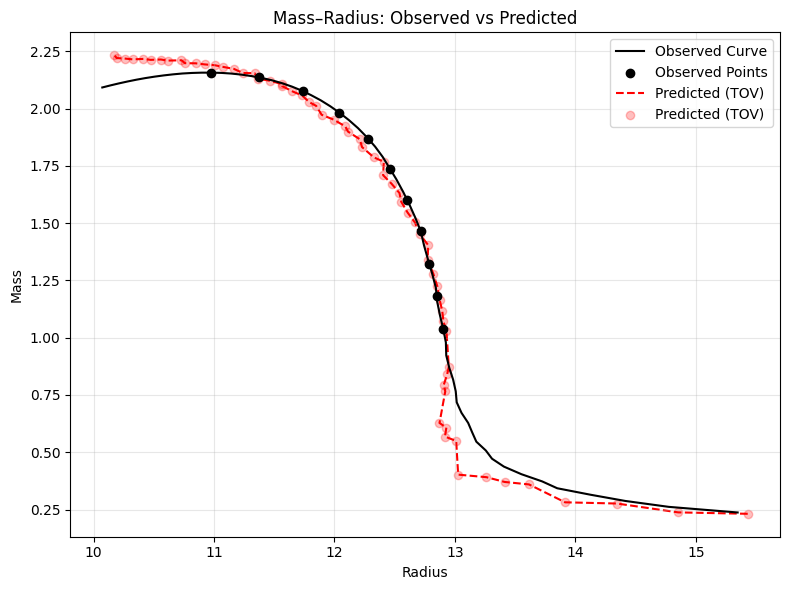

In [14]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(R_obs, 
        M_obs, color="black", label="Observed Curve", zorder=3)
plt.scatter(R_targets, M_targets, color="black", label="Observed Points", zorder=3)
plt.plot(r_pred, m_pred, "--", color="red", label="Predicted (TOV)", zorder=1)
plt.scatter(r_pred, m_pred, alpha=0.25, color="red", label="Predicted (TOV)", zorder=1)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.title("Mass–Radius: Observed vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

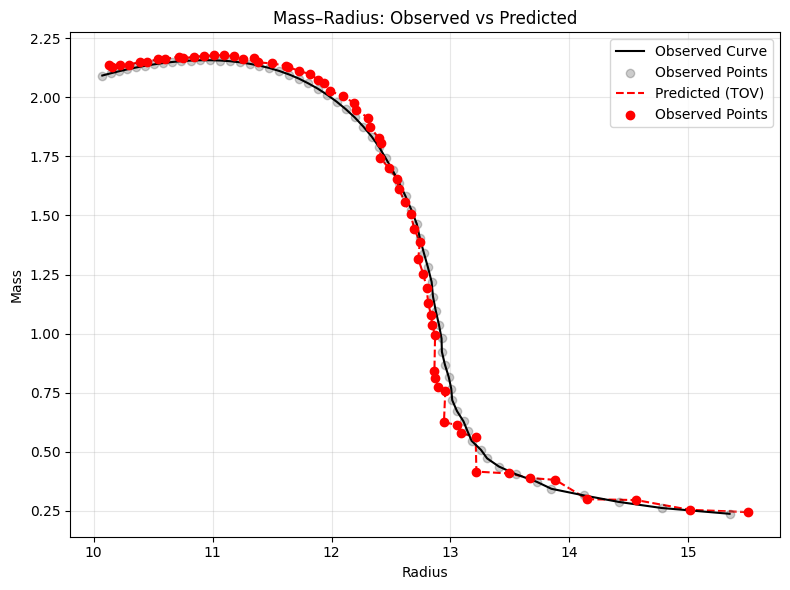

In [15]:
# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(R_obs, M_obs, color="black", label="Observed Curve", zorder=3)
plt.scatter(R_obs, M_obs, alpha=0.2, color="black", label="Observed Points", zorder=3)
plt.plot(radius, mass, "--", color="red", label="Predicted (TOV)", zorder=1)
plt.scatter(radius, mass, color="red", label="Observed Points", zorder=3)
plt.xlabel("Radius")
plt.ylabel("Mass")
plt.title("Mass–Radius: Observed vs Predicted")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
mr.shape

(64, 2)

In [17]:
M_obs = torch.from_numpy(M_scaled).float()
R_obs = torch.from_numpy(R_scaled).float()
dM_t  = torch.from_numpy(dM).float()
dR_t  = torch.from_numpy(dR).float()

criterion = chi2_loss(M_obs, R_obs, dM_t, dR_t)
print(criterion(torch.from_numpy(mr).float().unsqueeze(0)).item())


0.0009749768651090562


In [18]:
print(criterion(tov(p_pred)).item())

0.0010498383780941367


In [19]:
M_seq, R_seq = mr_pred_tensor[0,:,0], mr_pred_tensor[0,:,1]
total_loss = 0.0

# Exact paper computation
for i in range(len(M_obs)):
    distances = ((M_seq - M_obs[i])/(dM[i] + 1e-6))**2 + \
                ((R_seq - R_obs[i])/(dR[i] + 1e-6))**2
    
    min_idx = torch.argmin(distances)
    
    mass_chi2_term = ((M_seq[min_idx] - M_obs[i])/(dM[i] + 1e-6))**2
    radius_chi2_term = ((R_seq[min_idx] - R_obs[i])/(dR[i] + 1e-6))**2
print("Mass chi2 term:", mass_chi2_term.item())
print("Radius chi2 term:", radius_chi2_term.item())

Mass chi2 term: 0.00018263219681102782
Radius chi2 term: 1.634568252484314e-05


Realistic Scenario

In [20]:
res = np.load("data/realistic/realistic_predictions.npz")

M_MAX = res["M_MAX"]
R_MIN = res["R_MIN"]
R_MAX = res["R_MAX"]

rho_scaled = res["rho_scaled"]                         # (Np,)
p_pred_samples = res["p_pred_samples"]                 # (Nsamples, Np)
M_pred_samples = res["M_pred_samples"]                 # (Nsamples, Nseq)
R_pred_samples = res["R_pred_samples"]                 # (Nsamples, Nseq)

M_samples = res["M_samples"] * M_MAX
R_samples = res["R_samples"] * (R_MAX - R_MIN) + R_MIN
dM_samples = res["dM_samples"]
dR_samples = res["dR_samples"]

print(p_pred_samples.shape)
print(f"Training convergence rate: {42/200*100:.1f}%.")


FileNotFoundError: [Errno 2] No such file or directory: 'data/realistic/realistic_predictions.npz'

In [ ]:
true_eos = observed_eos.query("ID == 19248").query("model == 'RMFNL'")
p_mean = p_pred_samples.mean(axis=0)

In [ ]:
# plt.plot(rho_scaled, p_mean, "--", color="red", label="Mean EoS", zorder=4)
# plt.plot(true_eos["rho"].values, 
#         true_eos["p"].values, color="black", label="Observed EoS Curve", zorder=1)
# plt.xlabel("Density ( sat)")
# plt.ylabel("Pressure (MeV/fm³)")
# plt.title("Predicted Equation of State")
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# (Nsamples, Nseq)
mean_M = M_pred_samples.mean(axis=0) 

mean_R = R_pred_samples.mean(axis=0)

NameError: name 'radius_obs' is not defined

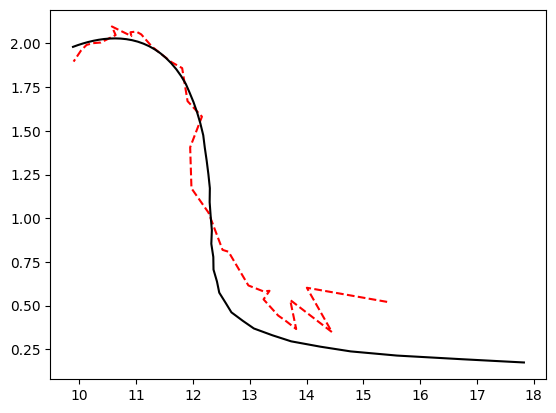

In [ ]:
plt.plot(mean_R, mean_M, "--", color="red", label="Mean MR", zorder=1)
plt.plot(observed_mr.query("ID == 19248").query("model == 'RMFNL'")["R"].values, 
        observed_mr.query("ID == 19248").query("model == 'RMFNL'")["M"].values, color="black", label="Observed Curve", zorder=4)
plt.scatter(radius_obs, mass_obs, color="black", label="Observed Points", zorder=4)
plt.scatter(R_samples.flatten(),M_samples.flatten(), color='lightblue', alpha=0.4, label="Samples", zorder=0)
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
plt.title("Predicted Mass–Radius Relation")
plt.legend()
plt.grid(True)
plt.show()

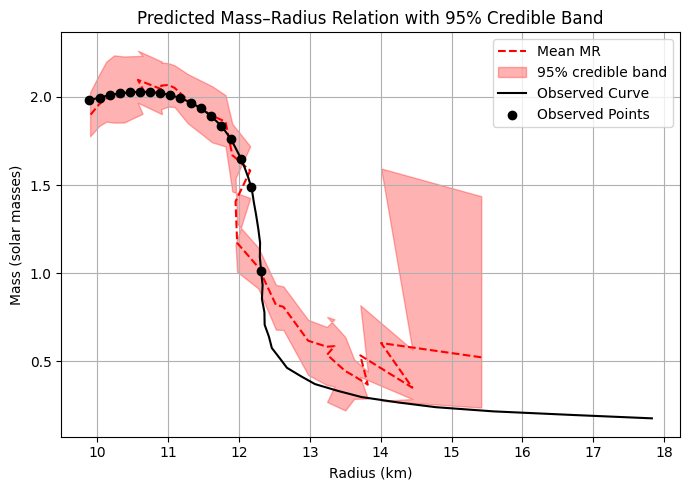

In [ ]:
mean_M = M_pred_samples.mean(axis=0)

lower_M = np.percentile(M_pred_samples, 2.5, axis=0)
upper_M = np.percentile(M_pred_samples, 97.5, axis=0)

plt.figure(figsize=(7, 5))
plt.plot(mean_R, mean_M, "--", label="Mean MR", color="red", zorder=2)

# 95% credible band
plt.fill_between(
    mean_R,
    lower_M,
    upper_M,
    alpha=0.3,
    label="95% credible band",
    zorder=1,
    color="red"
)

# Observed continuous curve (example: ID=19248, model='RMFNL')
mask = (observed_mr["ID"] == 19248) & (observed_mr["model"] == "RMFNL")
plt.plot(
    observed_mr.loc[mask, "R"].values,
    observed_mr.loc[mask, "M"].values,
    color="black",
    label="Observed Curve",
    zorder=3,
)

# Observed discrete points
plt.scatter(radius_obs, mass_obs, color="black", marker="o",
            label="Observed Points", zorder=4)

# Labels, legend, etc.
plt.xlabel("Radius (km)")
plt.ylabel("Mass (solar masses)")
plt.title("Predicted Mass–Radius Relation with 95% Credible Band")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()